## Сборный проект —2

## Описание проекта

### Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:\
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
Шаг 1. Загрузка данных\
Загрузите файлы с данными:
 - Тренировочная выборка: train_job_satisfaction_rate.csv
 - Входные признаки тестовой выборки: test_features.csv
 - Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv
Шаг 2. Предобработка данных\
Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.\
Шаг 3. Исследовательский анализ данных\
Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.\
Шаг 4. Подготовка данных\
Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки.\
 При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.\
Шаг 5. Обучение моделей\
Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений.\ 
Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.\
Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE \
(англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). \
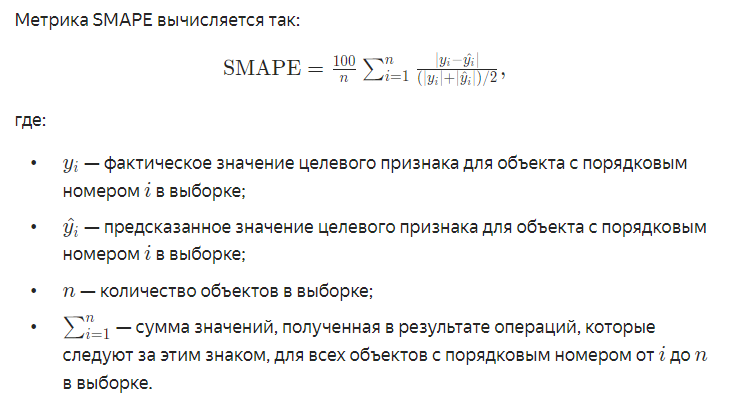\
Напишите функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. \
Используйте эту метрику при подборе гиперпараметров и оценке качества моделей. \
Критерий успеха: SMAPE ≤15 на тестовой выборке.\
В решении сохраните работу со всеми моделями, которые вы пробовали. Сделайте выводы.\
Шаг 6. Оформление выводов\
Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.\

#### План работы:
- Шаг 1. Загрузка данных;
- Шаг 2. Предобработка данных;
- Шаг 3. Исследовательский анализ данных;
- Шаг 4. Подготовка данных;
- Шаг 5. Обучение моделей;
- Шаг 6. Оформление выводов.

### Шаг 1. Загрузка и изучение данных;

##### Импорты

In [1]:
import sys
!{sys.executable} -m pip install -U scikit-learn -q
!{sys.executable} -m pip install -U imbalanced-learn -q
!{sys.executable} -m pip install shap -q
!{sys.executable} -m pip install imblearn -q
!{sys.executable} -m pip install phik -q

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
from scipy.stats import randint

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, KBinsDiscretizer, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sklearn
sklearn.__version__ 

'1.4.1.post1'

##### Загрузка датафреймов из csv

In [4]:
try:
    train_sat = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
except:
    train_sat = pd.read_csv('train_job_satisfaction_rate.csv', sep=',')
try:
    test_f = pd.read_csv('/datasets/test_features.csv', sep=',')
except:
    test_f = pd.read_csv('test_features.csv', sep=',')
try:
    test_sat = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')
except:
    test_sat = pd.read_csv('test_target_job_satisfaction_rate.csv', sep=',')

##### Просмотр данных

In [5]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    #describe
    display(data.describe())

##### Функция для графиков

Numerical

In [6]:
def visualize_data(data, cols):
    fig, axes = plt.subplots(len(cols), 2, figsize=(8, 4*len(cols)))

    for i, col in enumerate(cols):
        sns.histplot(data[col], kde=False, ax=axes[i, 0])
        axes[i, 0].set_title(f'Гистограмма для {col}')

        sns.boxplot(x=data[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Ящик с усами для {col}')

    plt.tight_layout()
    plt.show()

##### Object

In [7]:
def visualize_categorical_data(data, cols):
    num_plots = len(cols)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8, 4*num_plots))

    for i, col in enumerate(cols):
        sns.countplot(x=col, data=data, ax=ax[i])
        ax[i].set_title(f'Распределение значений для {col}')
        ax[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

##### SMARE

In [8]:
def smare(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))*100)

In [9]:
inform(train_sat)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Первые несколько строк датасета:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [10]:
inform(test_f)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Первые несколько строк датасета:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [11]:
inform(test_sat)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Первые несколько строк датасета:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


### Шаг 2. Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

#### Проверка на пропуски

In [12]:
print('==train_job_satisfaction_rate==')
print(train_sat.isna().sum())
print('==test_features==')
print(test_f.isna().sum())
print('==test_target_job_satisfaction_rate==')
print(test_sat.isna().sum())

==train_job_satisfaction_rate==
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
==test_features==
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
==test_target_job_satisfaction_rate==
id                       0
job_satisfaction_rate    0
dtype: int64


In [13]:
rows_with_missing_values_1 = train_sat[train_sat.isnull().any(axis=1)]
display(rows_with_missing_values_1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [14]:
train_sat['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [15]:
rows_with_missing_values_2 = test_f[test_f.isnull().any(axis=1)]
display(rows_with_missing_values_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


##### Заменяем отсутствующие значение на основе поиска схожих строк в датафрейме

#### Проверка на дубликаты

In [16]:
train_sat = train_sat.drop_duplicates()
test_f = test_f.drop_duplicates()
test_sat = test_sat.drop_duplicates()

print('==train_job_satisfaction_rate==')
print(train_sat.duplicated().sum())
print('==test_features==')
print(test_f.duplicated().sum())
print('==test_target_job_satisfaction_rate==')
print(test_sat.duplicated().sum())

==train_job_satisfaction_rate==
0
==test_features==
0
==test_target_job_satisfaction_rate==
0


In [17]:
train_sat.apply(lambda x: x.unique())

id                       [155278, 653870, 184592, 171431, 693419, 40544...
dept                     [sales, hr, technology, purchasing, marketing,...
level                                        [junior, middle, sinior, nan]
workload                                               [medium, high, low]
employment_years                           [2, 1, 4, 7, 9, 6, 3, 10, 8, 5]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [1, 5, 2, 3, 4]
salary                   [24000, 38400, 12000, 18000, 22800, 30000, 564...
job_satisfaction_rate    [0.58, 0.76, 0.11, 0.37, 0.2, 0.78, 0.56, 0.44...
dtype: object

In [18]:
test_f.apply(lambda x: x.unique())

id                       [485046, 686555, 467458, 418655, 789145, 42997...
dept                     [marketing, hr, sales, purchasing, technology,...
level                                        [junior, middle, sinior, nan]
workload                                            [medium, low, high,  ]
employment_years                           [2, 1, 5, 6, 3, 9, 7, 4, 8, 10]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [5, 4, 3, 1, 2]
salary                   [28800, 30000, 19200, 40800, 42000, 26400, 492...
dtype: object

In [19]:
test_sat.apply(lambda x: x.unique())

id                       [130604, 825977, 418490, 555320, 826430, 81721...
job_satisfaction_rate    [0.74, 0.75, 0.6, 0.72, 0.08, 0.76, 0.64, 0.38...
dtype: object

**Промежуточный вывод**: в процессе предобработки были выявлены пропуски и неявные дубликаты, которые мы, в последствии, обработаем в паплайне

### Шаг 3. Исследовательский анализ данных

Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.

##### Графический анализ

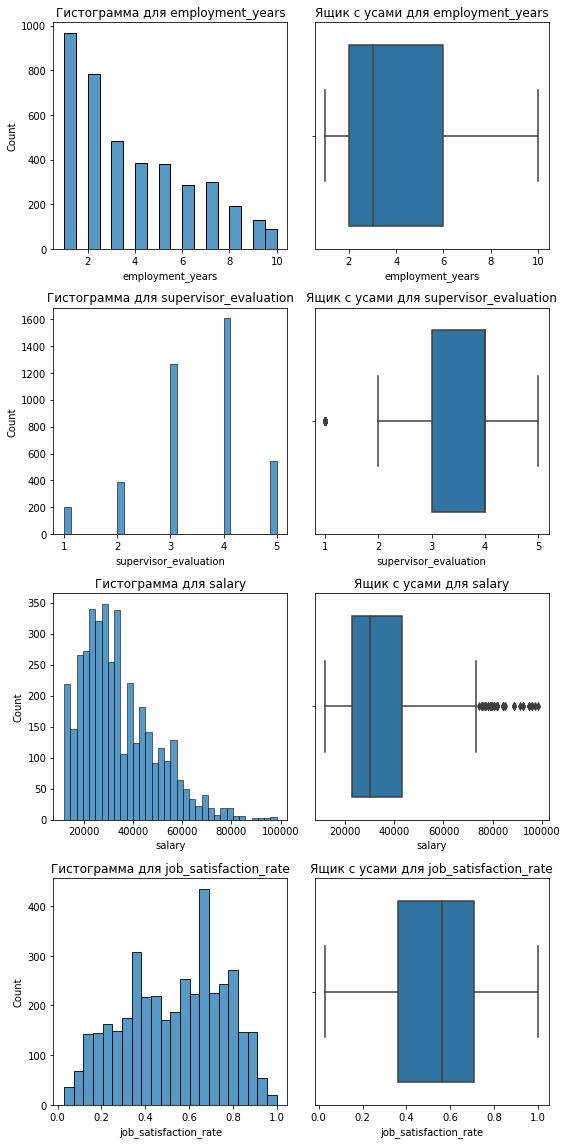

In [20]:
cols_to_visualize_ts = train_sat.select_dtypes(include=['float64', 'int64']).columns
cols_to_visualize_ts = cols_to_visualize_ts.drop('id')
visualize_data(train_sat, cols_to_visualize_ts)

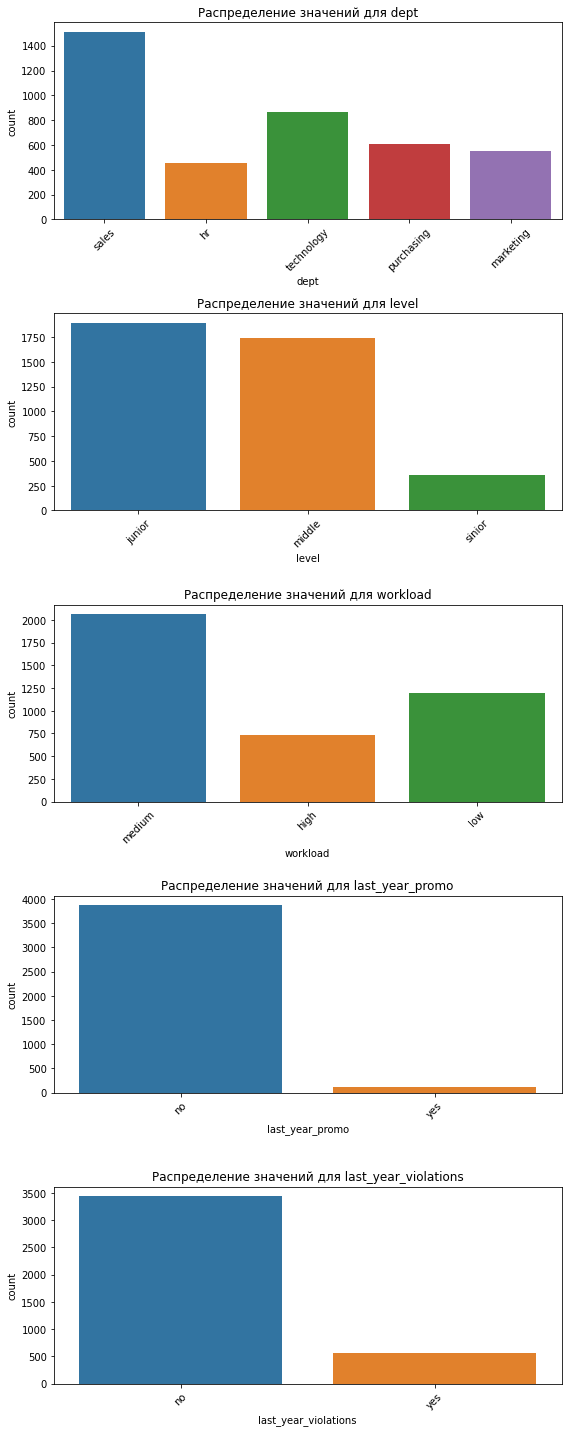

In [21]:
cols_to_visualize_cat = train_sat.select_dtypes(include=['object']).columns
visualize_categorical_data(train_sat, cols_to_visualize_cat)

**Вывод**: на основании рассмотренных выше графиков можно сделать следующие выводы:
1. Чаще всего люди работают в данной кампании 2-6 лет;
2. Чаще всего сотрудников оценивают на оценку "4";
3. Средняя з/п - 20-30 тыс, зп выше 60 000 равносильна выбросам;
4. Большая часть сотрудников удовлетворена работой на 60%;
5. В организации больше всего сотрудников в отделе продаж;
6. Специалистов уровня senior, ожидаемо, практически нет;
7. В предыдущем году практически не было повышений;
8. 1/8 сотрудников была замечена за нарушением трудового договора в предыдущем году.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

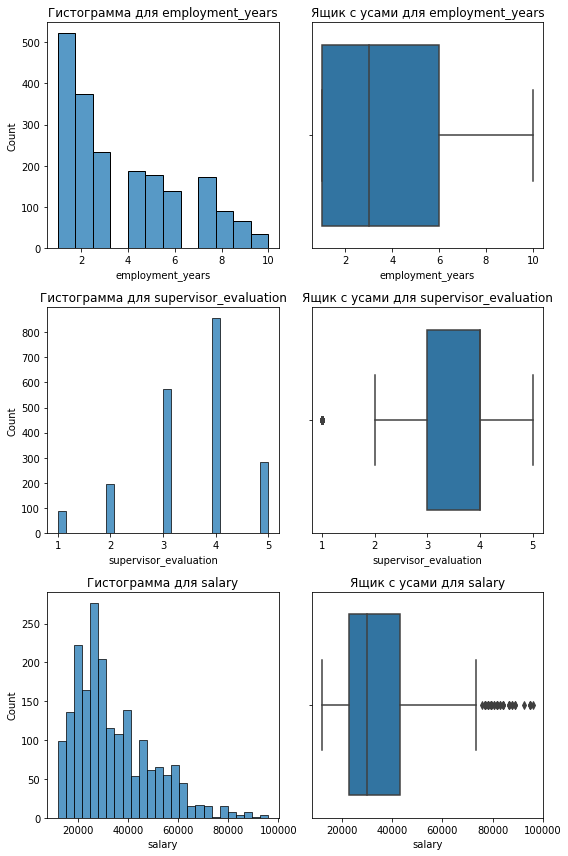

In [22]:
cols_to_visualize_tf = test_f.select_dtypes(include=['float64', 'int64']).columns
cols_to_visualize_tf = cols_to_visualize_tf.drop('id')
visualize_data(test_f, cols_to_visualize_tf)

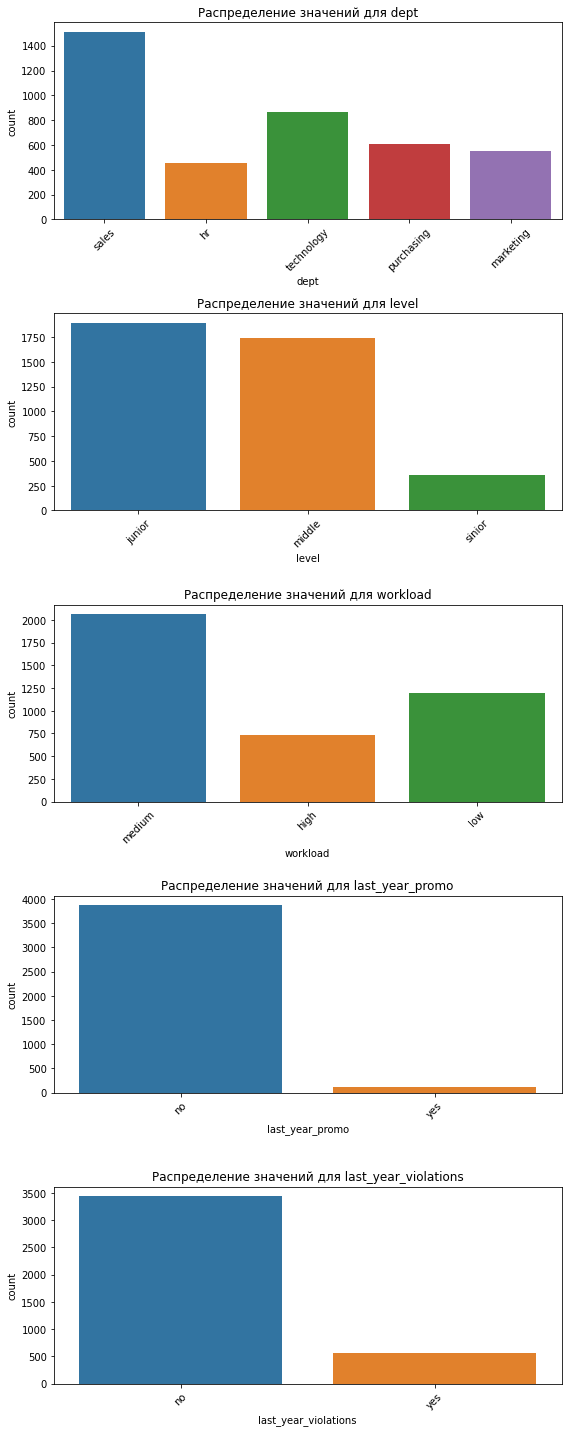

In [23]:
cols_to_visualize_cat = test_f.select_dtypes(include=['object']).columns
visualize_categorical_data(train_sat, cols_to_visualize_cat)

**Вывод**: на основании рассмотренных выше графиков можно сделать следующие выводы:
1. Чаще всего люди работают в данной кампании менее двух лет;
2. Чаще всего сотрудников оценивают на оценку "4";
3. Средняя з/п - 20-30 тыс, зп выше 60 000 равносильна выбросам;
4. В организации больше всего сотрудников в отделе продаж;
5. Специалистов уровня senior, ожидаемо, практически нет (но больше, чем в тренировочном);
6. Рабочая нагрузка у превалирующего числа работников средняя;
7. В предыдущем году практически не было повышений;
8. 1/8 сотрудников была замечена за нарушением трудового договора в предыдущем году.

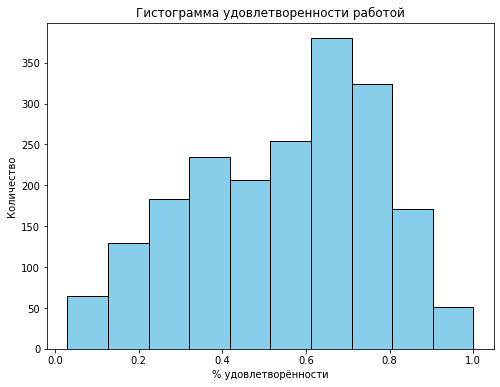

In [24]:
plt.figure(figsize=(8, 6))
plt.hist(test_sat['job_satisfaction_rate'], bins=10, color='skyblue', edgecolor='black')
plt.title('Гистограмма удовлетворенности работой')
plt.xlabel('% удовлетворённости')
plt.ylabel('Количество')
plt.show()

Как мы видим по гистограмме, большая часть сотрудников удовлетворена рабочим местом на 60-70%

Корреляционный анализ

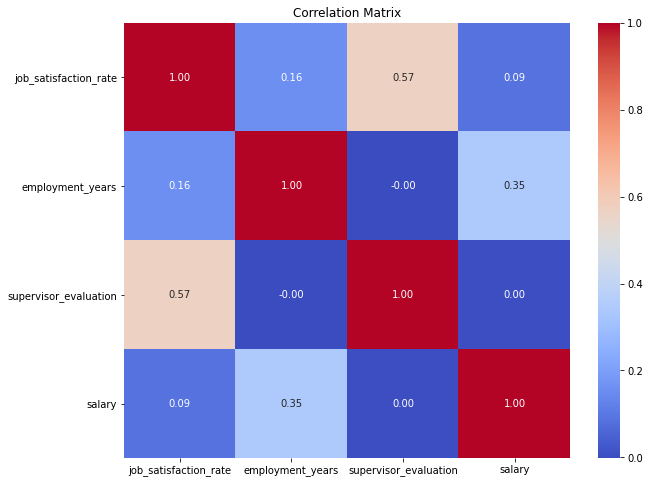

In [25]:
train_sat = train_sat[['job_satisfaction_rate', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']]
#добавлена строка для удаления дубликатов
try:
    train_sat = train_sat.drop(columns=['id'])
    train_sat.drop_duplicates(inplace=True)
except:
    None
    
num_data = train_sat.select_dtypes(include=['float64', 'int64'])

correlation_matrix = num_data.corr(method='kendall')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Корреляционный анализ показывает нам высокую степень корреляции с оценкой руководителя и небольшую с зарплатой

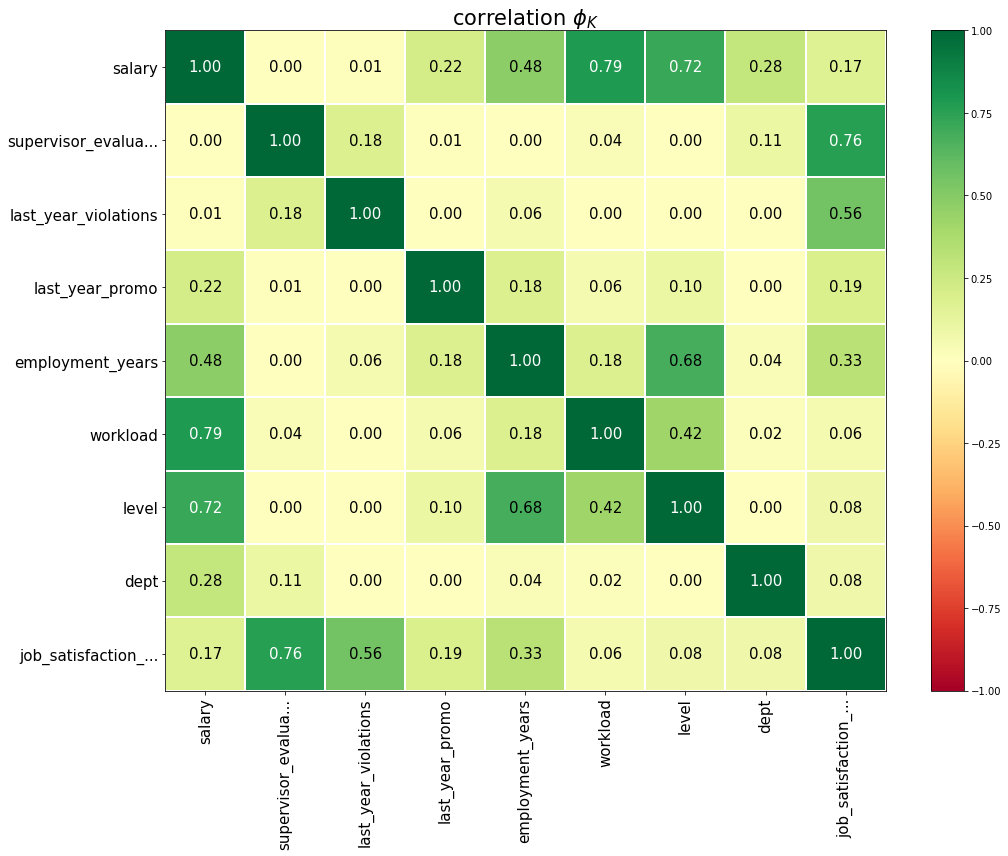

In [26]:
# список интервальных признаков
interval_cols = ['job_satisfaction_rate' , 'salary', 'employment_years', 'supervisor_evaluation']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = train_sat.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

In [27]:
train_sat.drop_duplicates(inplace=True)

In [28]:
train_sat.shape

(3755, 9)

### Шаг 4. Подготовка данных

Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. \
При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

##### Объединение датафреймов с тестовой выборкой

In [29]:
test_sf = pd.merge(test_f,test_sat,on='id', how='left')
test_sf = test_sf.drop('id',axis=1)
test_sf = test_sf[['job_satisfaction_rate', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']]
test_sf.head()

,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,0.79,marketing,junior,medium,2,no,no,5,28800
1,0.72,hr,junior,medium,1,no,no,4,30000
2,0.64,sales,middle,low,5,no,no,4,19200
3,0.60,sales,middle,low,6,no,no,4,19200
4,0.75,hr,middle,medium,5,no,no,5,40800


In [30]:
inform(test_sf)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


Первые несколько строк датасета:


,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,0.79,marketing,junior,medium,2,no,no,5,28800
1,0.72,hr,junior,medium,1,no,no,4,30000
2,0.64,sales,middle,low,5,no,no,4,19200
3,0.60,sales,middle,low,6,no,no,4,19200
4,0.75,hr,middle,medium,5,no,no,5,40800


,job_satisfaction_rate,employment_years,supervisor_evaluation,salary
count,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.54878,3.666500,3.526500,34066.800000
std,0.22011,2.537222,0.996892,15398.436729
min,0.03000,1.000000,1.000000,12000.000000
25%,0.38000,1.000000,3.000000,22800.000000
50%,0.58000,3.000000,4.000000,30000.000000
75%,0.72000,6.000000,4.000000,43200.000000
max,1.00000,10.000000,5.000000,96000.000000


In [31]:
train_sat.apply(lambda x: x.unique())

job_satisfaction_rate    [0.58, 0.76, 0.11, 0.37, 0.2, 0.78, 0.56, 0.44...
dept                     [sales, hr, technology, purchasing, marketing,...
level                                        [junior, middle, sinior, nan]
workload                                               [medium, high, low]
employment_years                           [2, 1, 4, 7, 9, 6, 3, 10, 8, 5]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [1, 5, 2, 3, 4]
salary                   [24000, 38400, 12000, 18000, 22800, 30000, 564...
dtype: object

In [32]:
test_sf.apply(lambda x: x.unique())

job_satisfaction_rate    [0.79, 0.72, 0.64, 0.6, 0.75, 0.67, 0.36, 0.73...
dept                     [marketing, hr, sales, purchasing, technology,...
level                                        [junior, middle, sinior, nan]
workload                                            [medium, low, high,  ]
employment_years                           [2, 1, 5, 6, 3, 9, 7, 4, 8, 10]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [5, 4, 3, 1, 2]
salary                   [28800, 30000, 19200, 40800, 42000, 26400, 492...
dtype: object

##### Предобработка паплайна

In [33]:
X_train = train_sat.drop('job_satisfaction_rate', axis=1)
y_train = train_sat['job_satisfaction_rate']

X_test = test_sf.drop('job_satisfaction_rate', axis=1)
y_test = test_sf['job_satisfaction_rate']

continuous_features_tr = ['salary']
discrete_features_tr = ['employment_years', 'supervisor_evaluation']

nominal_features = ['dept', 'last_year_promo', 'last_year_violations']
ordinal_features = ['level', 'workload']

# Числовые признаки
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('discretizer', KBinsDiscretizer(n_bins=10000, encode='onehot', strategy='uniform'))
])

# Дискретные признаки
discrete_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

# Ранговые признаки
ordinal_pipeline = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ord',  OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'sinior'], 
                ['low', 'medium', 'high'],
            ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)
# порядковые признаки
nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('imputer_pr', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Единый препроцессор
preprocessor = ColumnTransformer([
    ('continuous', continuous_pipeline, continuous_features_tr),
    ('discrete', discrete_pipeline, discrete_features_tr),
    ('ord_cat', ordinal_pipeline, ordinal_features),
    ('nom_cat', nominal_pipeline, nominal_features)
], remainder='passthrough')

preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('continuous',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('discretizer',
                                                  KBinsDiscretizer(n_bins=10000,
                                                                   strategy='uniform'))]),
                                 ['salary']),
                                ('discrete',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder())]),
                                 ['employm...
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('nom_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('imputer_pr',
                                                  SimpleImputer(missing_values=' ',
                                                                strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations'])])

In [34]:
# Модель линейной регрессии
model_pipeline_train_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression(fit_intercept=False))
])

# Модель древесной регрессии
model_pipeline_train_td = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

### Шаг 5. Обучение моделей

Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. \
Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.

Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE \
(англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Напишите функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. \
Используйте эту метрику при подборе гиперпараметров и оценке качества моделей. \
Критерий успеха: SMAPE ≤15 на тестовой выборке.

В решении сохраните работу со всеми моделями, которые вы пробовали. \
Сделайте выводы.

##### Обучение и оптимизация модели дерева решений

In [35]:
scorer = make_scorer(smare, greater_is_better=False)

##### Дерево

In [36]:
dt_param_grid = {
    'model__max_depth': [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(model_pipeline_train_td, dt_param_grid, scoring=scorer, cv=5)
dt_grid_search.fit(X_train, y_train)

model_pipeline_train_td.fit(X_train, y_train)

cv_scores = cross_val_score(dt_grid_search.best_estimator_, X_train, y_train, cv=5, scoring=scorer)

best_model_td = dt_grid_search.best_estimator_
predictions_td = best_model_td.predict(X_test)

print("Лучшие гиперпараметры для DecisionTreeRegressor:", dt_grid_search.best_params_)
print("Лучшая модель для DecisionTreeRegressor:", dt_grid_search.best_estimator_.named_steps['model'])
print("Лучшие параметры (Кросс-валидация) для DecisionTreeRegressor:", dt_grid_search.best_score_)

Лучшие гиперпараметры для DecisionTreeRegressor: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Лучшая модель для DecisionTreeRegressor: DecisionTreeRegressor(max_depth=20, min_samples_split=10)
Лучшие параметры (Кросс-валидация) для DecisionTreeRegressor: -16.403008212236276


##### Линейная модель

In [37]:
cv_scores = cross_val_score(model_pipeline_train_lr, X_train, y_train, cv=5, scoring=scorer)

model_pipeline_train_lr.fit(X_train, y_train)
predictions_lr = model_pipeline_train_lr.predict(X_test)

print("Cross-validated mean absolute error (SMARE) for LinearRegression:", -cv_scores.mean())

Cross-validated mean absolute error (SMARE) for LinearRegression: 24.514778202569623


##### SMARE

In [38]:
smare_td = smare(y_test, predictions_td)
print("SMARE для тестовой модели DecisionTreeRegressor:", smare_td)

smare_lr = smare(y_test, predictions_lr)
print("SMARE для тестовой модели LinearRegression:", smare_lr)

SMARE для тестовой модели DecisionTreeRegressor: 14.665533566242518
SMARE для тестовой модели LinearRegression: 22.9259764484243


### Шаг 6. Оформление выводов

В процессе выполнения Части 1 задания мы провели изучение и предобработку данных, с последующим изменением нулевых и неявных дубликатов в паплайне.\
Были созданы и проанализированы графики для всех задействованных датафреймов.\
После обучения паплайна на основе продаж (взятых на основе графика) были обучены модели линейной и древесной регрессии\
их smare равна:\
SMARE для тестовой модели DecisionTreeRegressor: 14.29797163316996\
SMARE для тестовой модели LinearRegression: 24.248594343178837

Таким образом лучшей моделью, попадающей под запрошенные значения менее 15 попадает только DecisionTreeRegressor

## Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. \
Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

### Шаг 1. Загрузка данных

In [39]:
try:
    train_q = pd.read_csv('/datasets/train_quit.csv', sep=',')
except:
    train_q = pd.read_csv('train_quit.csv', sep=',')
try:
    test_ft = pd.read_csv('/datasets/test_features.csv', sep=',')
except:
    test_ft = pd.read_csv('test_features.csv', sep=',')
try:
    test_tq = pd.read_csv('/datasets/test_target_quit.csv', sep=',')
except:
    test_tq = pd.read_csv('test_target_quit.csv', sep=',')

### Шаг 2. Предобработка данных

In [40]:
inform(train_q)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Первые несколько строк датасета:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [41]:
inform(test_ft)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Первые несколько строк датасета:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [42]:
inform(test_tq)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Первые несколько строк датасета:


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


##### Проверка на пропуски

In [43]:
print('==train_quit==')
print(train_q.isna().sum())
print('==test_features==')
print(test_ft.isna().sum())
print('==test_target_quit==')
print(test_tq.isna().sum())

==train_quit==
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
==test_features==
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
==test_target_quit==
id      0
quit    0
dtype: int64


In [44]:
rows_with_missing_values_3 = test_ft[test_ft.isnull().any(axis=1)]
display(rows_with_missing_values_3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


##### Проверка на дупликаты

In [45]:
train_q = train_q.drop_duplicates()
test_ft = test_ft.drop_duplicates()
test_tq = test_tq.drop_duplicates()

print('==train_quit==')
print(train_q.duplicated().sum())
print('==test_features==')
print(test_ft.duplicated().sum())
print('==test_target_quit==')
print(test_tq.duplicated().sum())

==train_quit==
0
==test_features==
0
==test_target_quit==
0


In [46]:
train_q.apply(lambda x: x.unique())

id                       [723290, 814010, 155091, 257132, 910140, 69991...
dept                        [sales, purchasing, marketing, technology, hr]
level                                             [middle, junior, sinior]
workload                                               [high, medium, low]
employment_years                           [2, 5, 1, 8, 4, 7, 3, 9, 6, 10]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [4, 1, 3, 5, 2]
salary                   [54000, 27600, 37200, 24000, 25200, 18000, 444...
quit                                                             [no, yes]
dtype: object

In [47]:
test_ft.apply(lambda x: x.unique())

id                       [485046, 686555, 467458, 418655, 789145, 42997...
dept                     [marketing, hr, sales, purchasing, technology,...
level                                        [junior, middle, sinior, nan]
workload                                            [medium, low, high,  ]
employment_years                           [2, 1, 5, 6, 3, 9, 7, 4, 8, 10]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [5, 4, 3, 1, 2]
salary                   [28800, 30000, 19200, 40800, 42000, 26400, 492...
dtype: object

In [48]:
test_tq.apply(lambda x: x.unique())

id      [999029, 372846, 726767, 490105, 416898, 22306...
quit                                            [yes, no]
dtype: object

Как мы видим, наш датафрейм содержит пропуски и некорректные значения. Заполним их в паплайне

### Шаг 3. Исследовательский анализ данных

3.1. Проведите исследовательский анализ данных.\
3.2. Составьте портрет «уволившегося сотрудника».\
 Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. \
 Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.\
3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. \
Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников.\
 Используйте данные с обоими целевыми признаками тестовой выборки.

#### 3.1

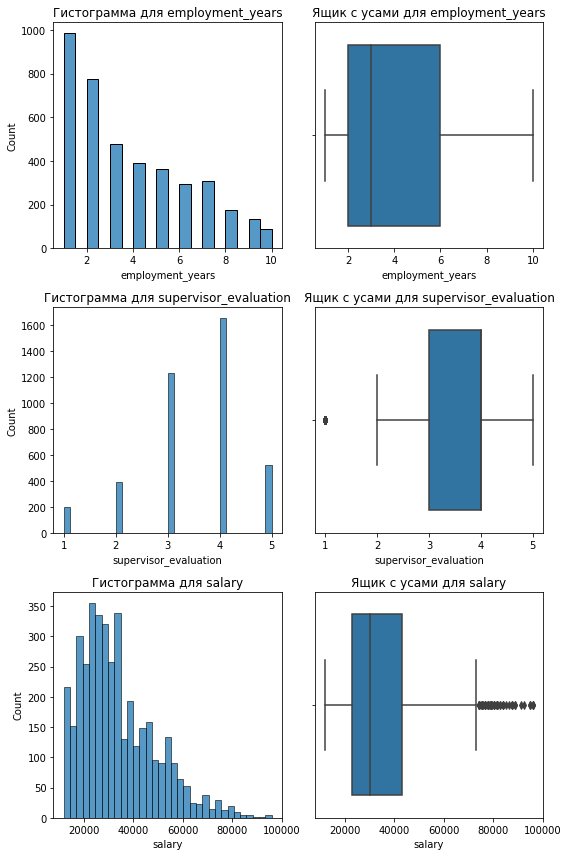

In [49]:
cols_to_visualize_tq = train_q.select_dtypes(include=['float64', 'int64']).columns
cols_to_visualize_tq = cols_to_visualize_tq.drop('id')
visualize_data(train_q, cols_to_visualize_tq)

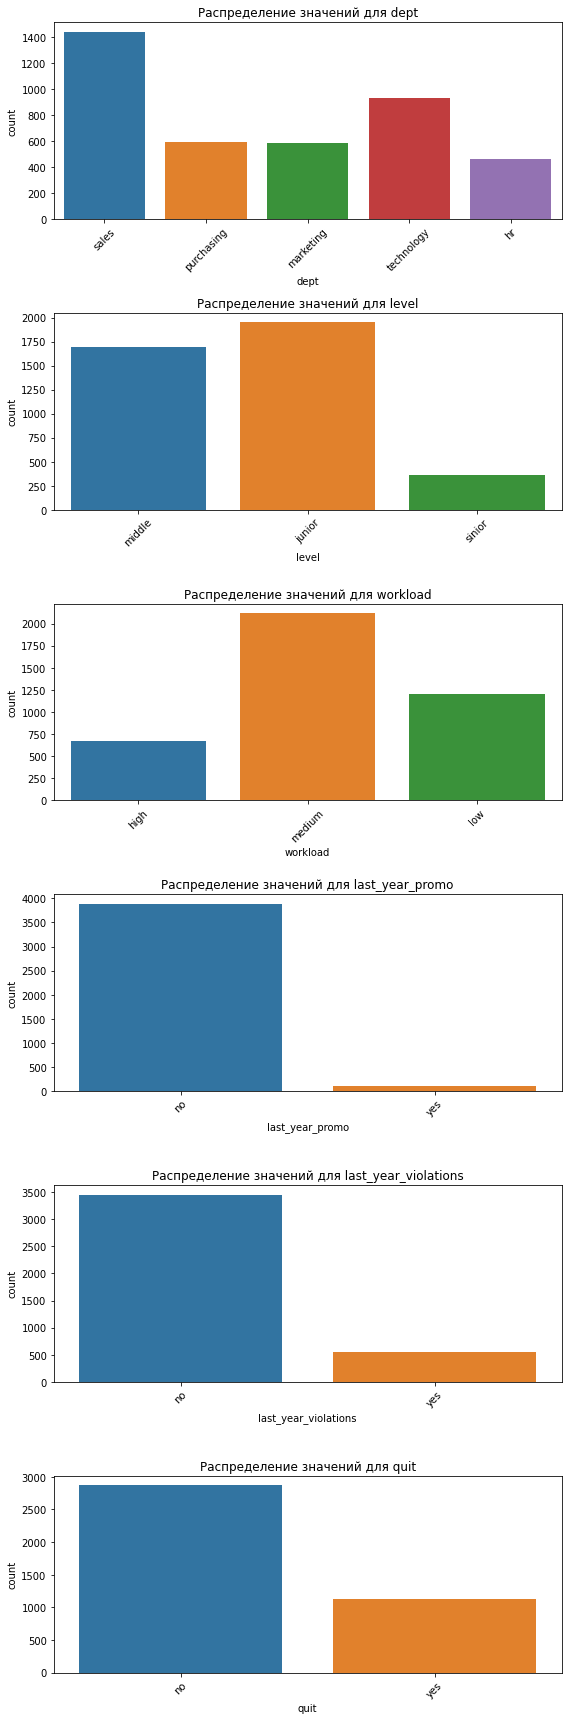

In [50]:
cols_to_visualize_catq = train_q.select_dtypes(include=['object']).columns
visualize_categorical_data(train_q, cols_to_visualize_catq)

**Вывод**: на основании рассмотренных выше графиков можно сделать следующие выводы:
1. Чаще всего люди работают в данной кампании не более трех лет;
2. Чаще всего сотрудников оценивают на оценку "4";
3. Средняя з/п - 20-30 тыс, зп выше 70 000 равносильна выбросам;
4. В организации больше всего сотрудников в отделе продаж;
5. Специалистов уровня senior, ожидаемо, практически нет;
6. Рабочая нагрузка превалирующего большинства - средняя;
7. В предыдущем году практически не было повышений;
8. 1/8 сотрудников была замечена за нарушением трудового договора в предыдущем году.

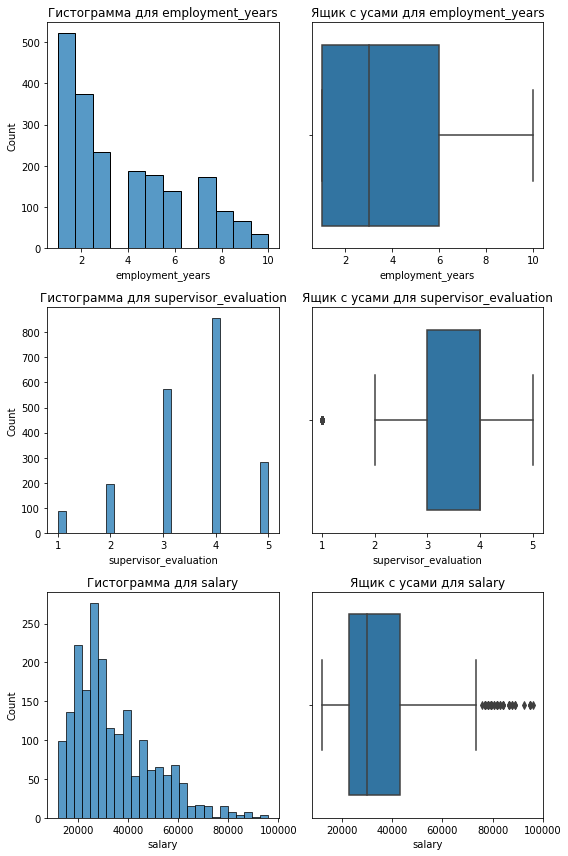

In [51]:
cols_to_visualize_tst = test_ft.select_dtypes(include=['float64', 'int64']).columns
cols_to_visualize_tst = cols_to_visualize_tst.drop('id')
visualize_data(test_ft, cols_to_visualize_tst)

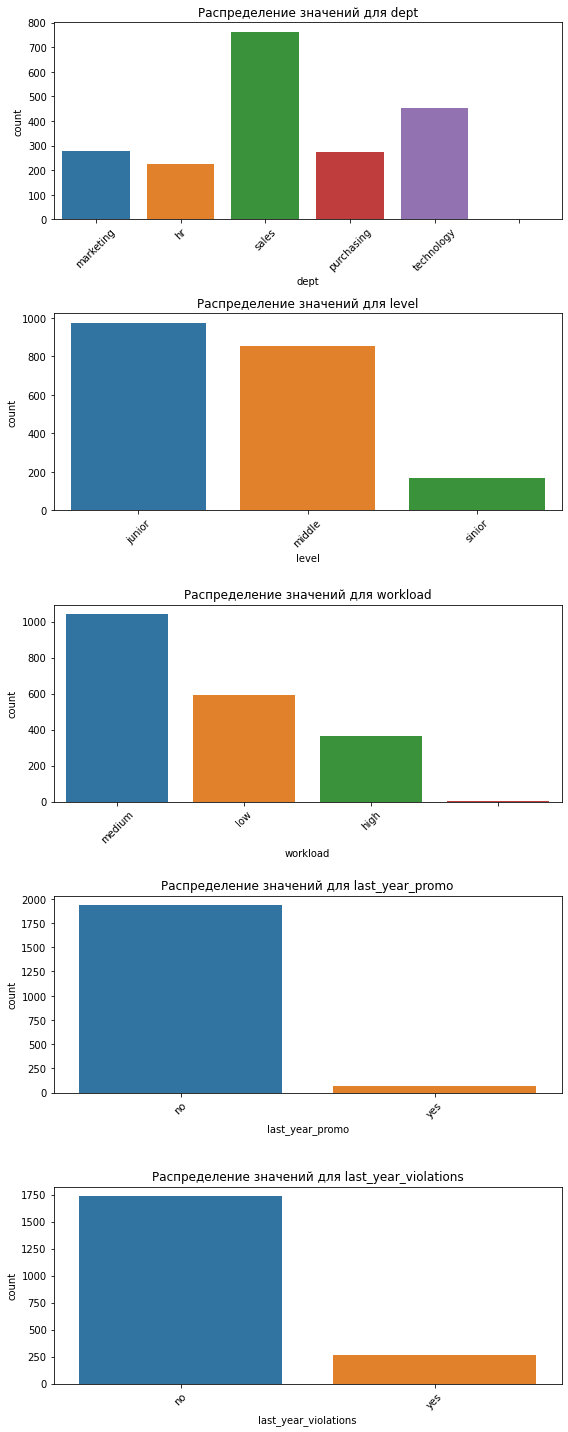

In [52]:
cols_to_visualize_catqt = test_ft.select_dtypes(include=['object']).columns
visualize_categorical_data(test_ft, cols_to_visualize_catqt)

**Вывод**: на основании рассмотренных выше графиков можно сделать следующие выводы:
1. Чаще всего люди работают в данной кампании не более трех лет;
2. Чаще всего сотрудников оценивают на оценку "4";
3. Средняя з/п - 20-30 тыс, зп выше 70 000 равносильна выбросам;
4. В организации больше всего сотрудников в отделе продаж;
5. Специалистов уровня senior, ожидаемо, практически нет;
6. Рабочая нагрузка превалирующего большинства - средняя;
7. В предыдущем году практически не было повышений;
8. 1/8 сотрудников была замечена за нарушением трудового договора в предыдущем году.

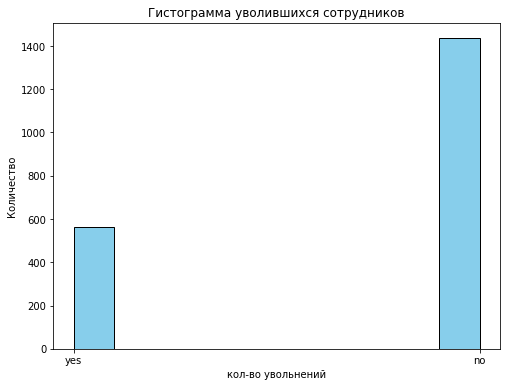

In [53]:
plt.figure(figsize=(8, 6))
plt.hist(test_tq['quit'], bins=10, color='skyblue', edgecolor='black')
plt.title('Гистограмма уволившихся сотрудников')
plt.xlabel('кол-во увольнений')
plt.ylabel('Количество')
plt.show()

На основании графика мы видим, что соотношение уволившихся находится на уровне 3 к 7, то есть почти четверть сотрудников оказалась не удовлетворена текущим местом работы и ушла.

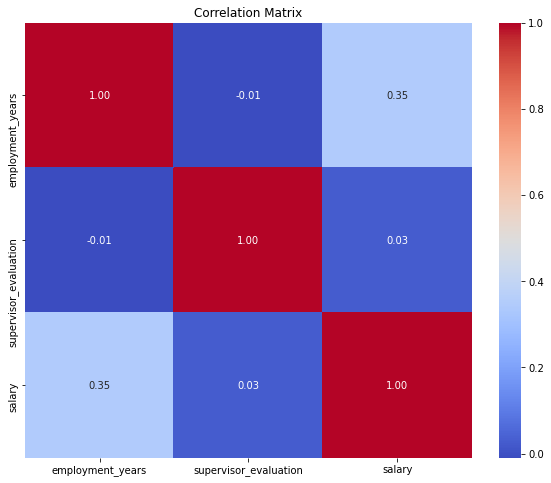

In [54]:
train_q = train_q[['quit', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']]

num_data = train_q.select_dtypes(include=['float64', 'int64'])

correlation_matrix = num_data.corr(method='kendall')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

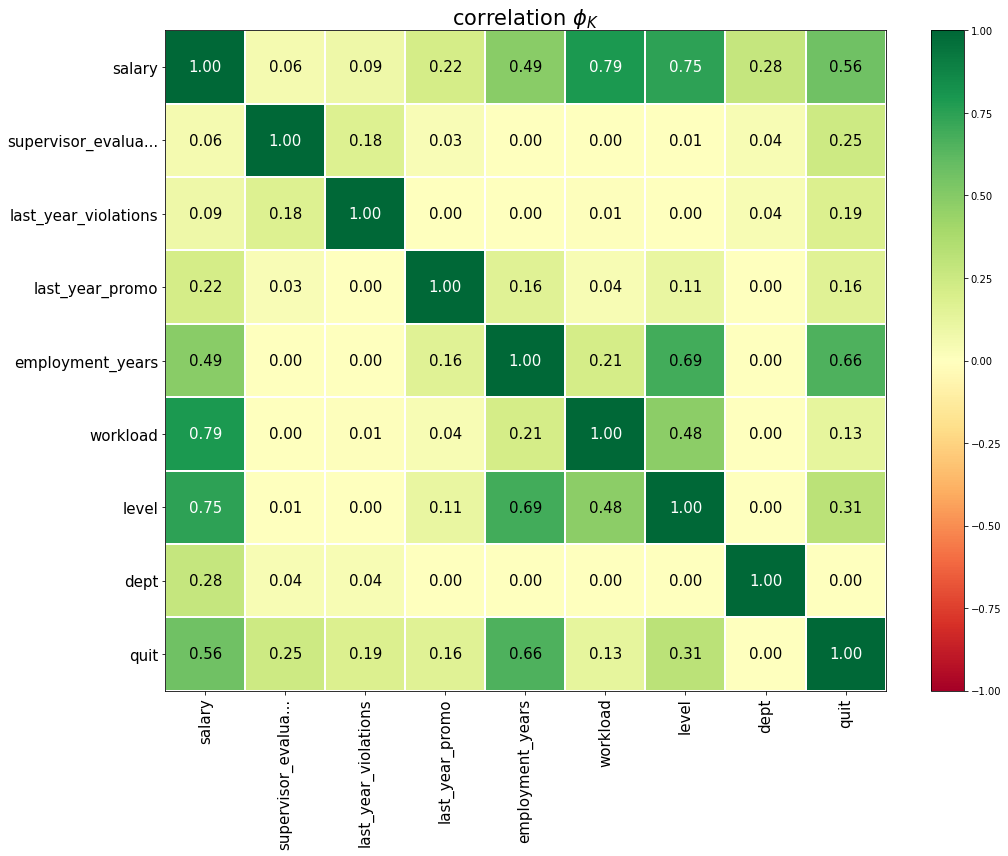

In [55]:
# список интервальных признаков
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = train_q.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Корреляционный анализ демонстрирует нам (на основе salary):
- высокую степень корреляции с workload и level
- среднюю корреляцию с emloyment_years и quit
- низкую степень корреляции с qept и last_year_promo

#### 3.2

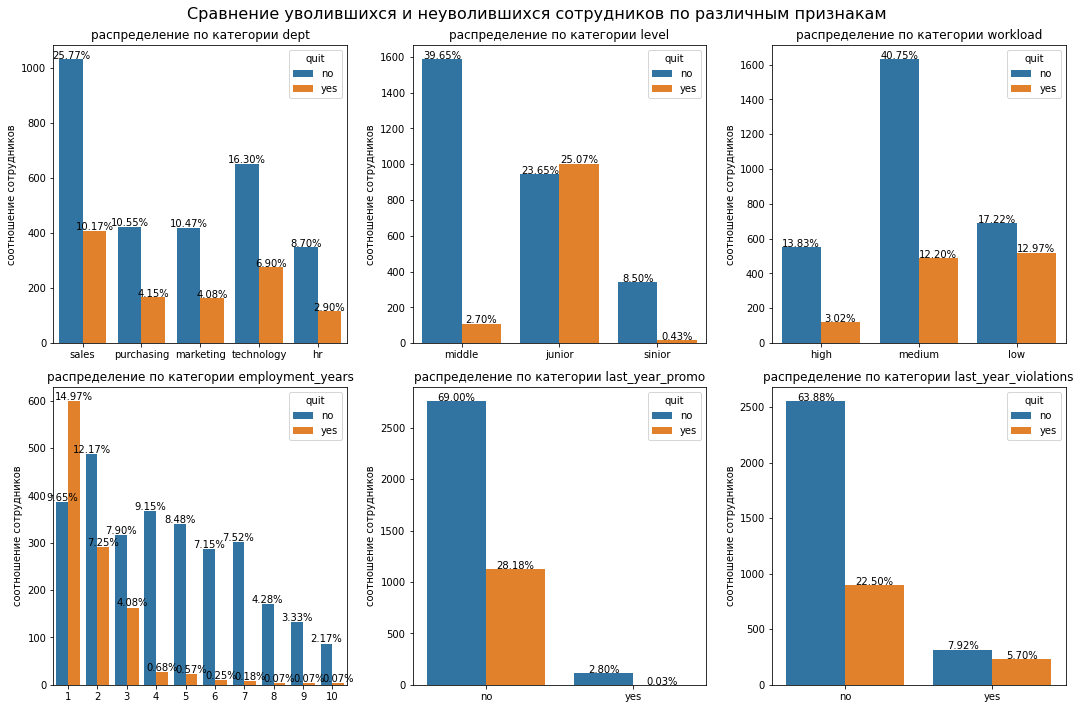

In [56]:
def create_employee_comparison(data, column, ax):
    total = float(len(data))
    sns.countplot(x=column, hue='quit', data=data, ax=ax)
    ax.set_title(f'распределение по категории {column}')
    ax.set_xlabel('')
    ax.set_ylabel('соотношение сотрудников')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format((height / total) * 100), ha="center")

# Создание подзаголовка для графика
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Сравнение уволившихся и неуволившихся сотрудников по различным признакам', fontsize=16)

# Применение функции для каждого категориального столбца
categorical_columns = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations']
for i, col in enumerate(categorical_columns):
    create_employee_comparison(train_q, col, ax=axes[i//3, i%3])

plt.tight_layout()
plt.show()

Таким образом мы получаем следующий портрет:
1. Должность не оказывает существенного влияния, но процентно чаще уходят сотрудники отделов продаж и маркетинга;
2. Самая большая текучка среди джунов;
3. Недостаток загруженности плохо влияет на сохранение работников;
4. Статистика показывает, что если сотрудник не уволился в первые два-три года, то шансы на его уход минимальны;
5. Отсутствие карьерного роста - ещё одна из причин ухода;
6. Оценка руководителем уровня компетентности работника не оказывает существенного внимания на его увольнение;

#### 3.3

In [57]:
test_qs = pd.merge(test_ft, test_tq[['id', 'quit']], on='id', how='left')
test_qr = pd.merge(test_qs, test_sat[['id', 'job_satisfaction_rate']], on='id', how='left')
test_qr = test_qr.drop('id',axis=1)
test_qr = test_qr[['job_satisfaction_rate', 'quit', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']]
test_qr.head()

,job_satisfaction_rate,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,0.79,no,marketing,junior,medium,2,no,no,5,28800
1,0.72,no,hr,junior,medium,1,no,no,4,30000
2,0.64,no,sales,middle,low,5,no,no,4,19200
3,0.60,no,sales,middle,low,6,no,no,4,19200
4,0.75,no,hr,middle,medium,5,no,no,5,40800


<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> 👍</font>

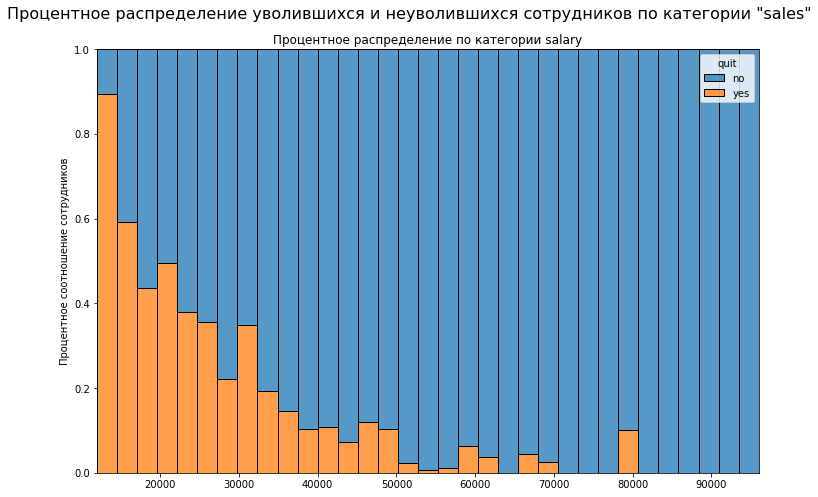

In [58]:
def create_employee_comparison(data, column, ax):
    total = float(len(data))
    sns.histplot(data=data, x=column, hue='quit', multiple='fill', ax=ax)
    ax.set_title(f'Процентное распределение по категории {column}')
    ax.set_xlabel('')
    ax.set_ylabel('Процентное соотношение сотрудников')
    
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.suptitle('Процентное распределение уволившихся и неуволившихся сотрудников по категории "sales"', fontsize=16)

create_employee_comparison(train_q, 'salary', ax=ax)

plt.tight_layout()
plt.show()

FixedFormatter should only be used together with FixedLocator


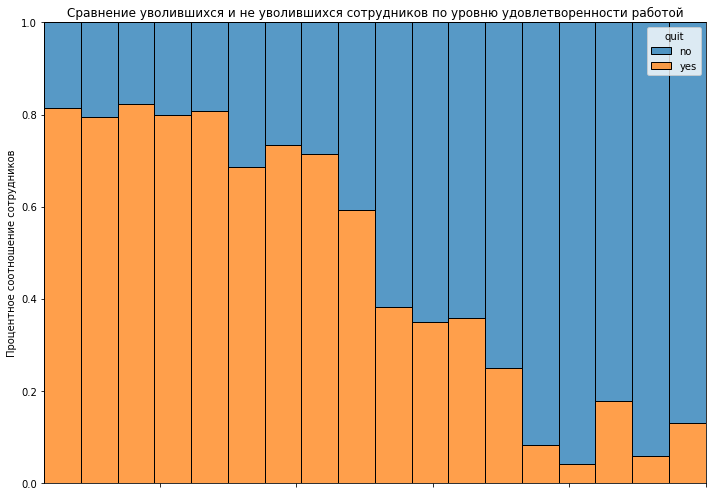

In [59]:
def create_employee_comparison(data, column, ax):
    sns.histplot(data=data, x=column, hue='quit', multiple='fill', stat='density', common_norm=False, ax=ax)
    ax.set_title(f'Процентное распределение по категории {column}')
    ax.set_xlabel('')
    ax.set_ylabel('Процентное соотношение сотрудников')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig, ax2 = plt.subplots(1, 1, figsize=(10, 7))
create_employee_comparison(test_qr, 'job_satisfaction_rate', ax2)
plt.title('Сравнение уволившихся и не уволившихся сотрудников по уровню удовлетворенности работой')
plt.tight_layout()
plt.show()

FixedFormatter should only be used together with FixedLocator


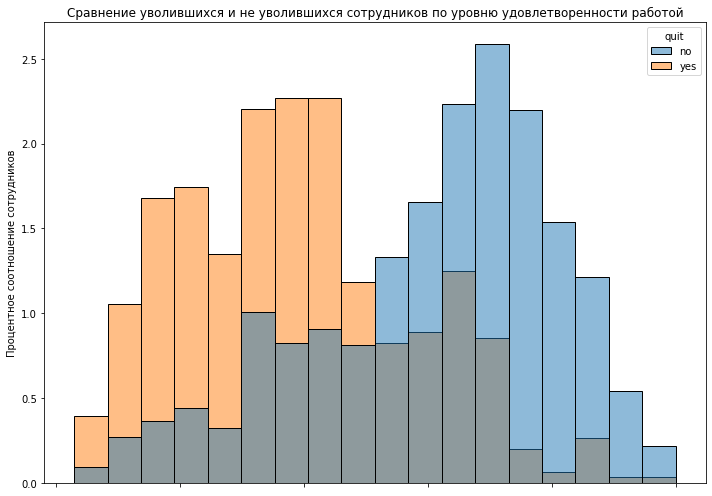

In [60]:
def create_employee_comparison(data, column, ax):
    sns.histplot(data=data, x=column, hue='quit', stat='density', common_norm=False, ax=ax)
    ax.set_title(f'Процентное распределение по категории {column}')
    ax.set_xlabel('')
    ax.set_ylabel('Процентное соотношение сотрудников')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig, ax2 = plt.subplots(1, 1, figsize=(10, 7))
create_employee_comparison(test_qr, 'job_satisfaction_rate', ax2)
plt.title('Сравнение уволившихся и не уволившихся сотрудников по уровню удовлетворенности работой')
plt.tight_layout()
plt.show()

З/П уволившися сотрудников обычно не привышает 30 000, а так же соотношение неудовлетворенных работой равно 3 к 7.
Как мы видим, практически все уволившиеся сотрудники имели процент удовлетворенности рабочим местом менее 60%

### Шаг 4. Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче.\
 Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

##### Тренировочная выботка

Учитывая, что нашей лучшей моделью стала древесная - будем предсказывать на её основе

In [61]:
X_tr_jsr = train_q

y_pred_tr_jsr = model_pipeline_train_td.predict(X_tr_jsr)

train_qf = train_q.copy()
train_qf['job_satisfaction_rate'] = y_pred_tr_jsr

display(train_qf.head())

,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,no,sales,middle,high,2,no,no,4,54000,0.632000
1,no,sales,junior,medium,2,no,no,4,27600,0.846364
2,no,purchasing,middle,medium,5,no,no,1,37200,0.380000
3,yes,sales,junior,medium,2,no,yes,3,24000,0.380000
4,no,marketing,junior,medium,2,no,no,5,25200,0.690000


##### Тестовая выборка

In [62]:
X_te_jsr = test_qr

model_pipeline_train_td.fit(X_test, y_test)

y_pred_te_jsr = model_pipeline_train_td.predict(X_te_jsr)

predicted_df = pd.DataFrame(data=y_pred_te_jsr, index=X_te_jsr.index, columns=['job_satisfaction_rate'])

test_qf = pd.concat([test_qr, predicted_df], axis=1)

test_qf = test_qf.loc[:,~test_qf.columns.duplicated()]
test_qf = test_qf.dropna(subset=['job_satisfaction_rate'])
display(test_qf.head())
test_qf.info()

,job_satisfaction_rate,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,0.79,no,marketing,junior,medium,2,no,no,5,28800
1,0.72,no,hr,junior,medium,1,no,no,4,30000
2,0.64,no,sales,middle,low,5,no,no,4,19200
3,0.60,no,sales,middle,low,6,no,no,4,19200
4,0.75,no,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
 1   quit                   2000 non-null   object 
 2   dept                   1998 non-null   object 
 3   level                  1999 non-null   object 
 4   workload               2000 non-null   object 
 5   employment_years       2000 non-null   int64  
 6   last_year_promo        2000 non-null   object 
 7   last_year_violations   2000 non-null   object 
 8   supervisor_evaluation  2000 non-null   int64  
 9   salary                 2000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 171.9+ KB


### Шаг 5. Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. \
При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

##### Предобработка паплайна

In [63]:
train_qf.drop_duplicates(inplace=True)
print(train_qf.duplicated().sum().sum())
train_qf.apply(lambda x: x.unique())

0


quit                                                             [no, yes]
dept                        [sales, purchasing, marketing, technology, hr]
level                                             [middle, junior, sinior]
workload                                               [high, medium, low]
employment_years                           [2, 5, 1, 8, 4, 7, 3, 9, 6, 10]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [4, 1, 3, 5, 2]
salary                   [54000, 27600, 37200, 24000, 25200, 18000, 444...
job_satisfaction_rate    [0.632, 0.8463636363636362, 0.38, 0.69, 0.07, ...
dtype: object

In [64]:
test_qf.apply(lambda x: x.unique())

job_satisfaction_rate    [0.79, 0.72, 0.64, 0.6, 0.75, 0.67, 0.36, 0.73...
quit                                                             [no, yes]
dept                     [marketing, hr, sales, purchasing, technology,...
level                                        [junior, middle, sinior, nan]
workload                                            [medium, low, high,  ]
employment_years                           [2, 1, 5, 6, 3, 9, 7, 4, 8, 10]
last_year_promo                                                  [no, yes]
last_year_violations                                             [no, yes]
supervisor_evaluation                                      [5, 4, 3, 1, 2]
salary                   [28800, 30000, 19200, 40800, 42000, 26400, 492...
dtype: object

Как мы видим, в паплайне есть пропущенные значения, обработаем их в паплайне

##### Преобразование непрерывнвных переменных, используя binning

In [74]:
X_train_2 = train_qf.drop(['quit'], axis=1)
y_train_2 = train_qf['quit']

X_test_2 = test_qf.drop(['quit'], axis=1)
y_test_2 = test_qf['quit']

continuous_features_tr_2 = ['job_satisfaction_rate', 'salary']
discrete_features_tr_2 = ['employment_years', 'supervisor_evaluation']

ordinal_features_2 = [ 'dept', 'last_year_promo', 'last_year_violations']
nominal_features_2 = ['level', 'workload']


# Непрерывные признаки
continuous_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('discretizer', KBinsDiscretizer(n_bins=100, encode='onehot', strategy='uniform'))
])

# Дискретные признаки
discrete_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Объединение
numerical_preprocessor_2 = ColumnTransformer([
    ('continuous', continuous_pipeline_2, continuous_features_tr_2),
    ('discrete', discrete_pipeline_2, discrete_features_tr_2)
], remainder='passthrough')

# Ранговые признаки
ordinal_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('imputer_pr', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

# порядковые признаки
nominal_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('imputer_pr', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Единый препроцессор
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor_2, continuous_features_tr_2 + discrete_features_tr_2),
        ('ord_cat', ordinal_pipeline_2, ordinal_features_2),
        ('nom_cat', nominal_pipeline_2, nominal_features_2)
    ], 
    remainder='passthrough')

preprocessor_2.fit(X_train_2)


label_encoder = LabelEncoder()
y_train_2_encoded = label_encoder.fit_transform(y_train_2)

In [75]:

# Модель логистической регрессии
model_pipeline_train_lr_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('model', LogisticRegression(max_iter=1000))
])

# Модель случайного леса для классификации
model_pipeline_train_rf_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('model', RandomForestClassifier())
])

# Создание объекта модели дерева решений
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('model', DecisionTreeClassifier())
])

### Шаг 6. Обучение модели

Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.\
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. \
Напомним: отбор признаков часто помогает улучшить метрику.

##### Обучение и вычисление ROC-AUC

In [76]:
scorer_ra = make_scorer(roc_auc_score, needs_threshold=True)

##### LogisticRegression

In [77]:
model_pipeline_train_lr_2.fit(X_train_2, y_train_2_encoded)

cross_val_scores_lr = cross_val_score(model_pipeline_train_lr_2, X_train_2, y_train_2_encoded, cv=5, scoring=scorer_ra)
print("Средняя оценка ROC-AUC через кросс-валидацию для линейной регрессии:", np.mean(cross_val_scores_lr))

Средняя оценка ROC-AUC через кросс-валидацию для линейной регрессии: 0.9048853847827603


##### RandomForestClassifier

In [78]:
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(5, 20),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10)
}

random_search_rf = RandomizedSearchCV(model_pipeline_train_rf_2, param_distributions=param_dist, n_iter=20, scoring=scorer_ra, cv=3, error_score='raise')
random_search_rf.fit(X_train_2, y_train_2_encoded)
print("Лучшие гиперпараметры для RandomForestClassifier:", random_search_rf.best_params_)

cross_val_scores_rf = cross_val_score(random_search_rf.best_estimator_, X_train_2, y_train_2_encoded, cv=3, scoring=scorer_ra)
print("Средняя оценка ROC-AUC через кросс-валидацию для RandomForestClassifier:", np.mean(cross_val_scores_rf))

Лучшие гиперпараметры для RandomForestClassifier: {'model__max_depth': 19, 'model__min_samples_leaf': 3, 'model__min_samples_split': 11, 'model__n_estimators': 480}
Средняя оценка ROC-AUC через кросс-валидацию для RandomForestClassifier: 0.9131564474440039


##### DecisionTreeClassifier

In [79]:
param_dist = {
    'model__max_depth': [3, 5, 10, None],
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10)
}

random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist, n_iter=20, scoring=scorer_ra, cv=3, error_score='raise')
random_search_dt.fit(X_train_2, y_train_2_encoded)
print("Лучшие гиперпараметры для DecisionTreeClassifier:", random_search_dt.best_params_)

cross_val_scores_dt = cross_val_score(random_search_dt.best_estimator_, X_train_2, y_train_2_encoded, cv=3, scoring=scorer_ra)
print("Средняя оценка ROC-AUC через кросс-валидацию для DecisionTreeClassifier:", np.mean(cross_val_scores_dt))

Лучшие гиперпараметры для DecisionTreeClassifier: {'model__max_depth': 5, 'model__min_samples_leaf': 9, 'model__min_samples_split': 13}
Средняя оценка ROC-AUC через кросс-валидацию для DecisionTreeClassifier: 0.9112251026545112


In [80]:
predictions_lr_2 = model_pipeline_train_lr_2.predict_proba(X_test_2)
predictions_lr_2_1 = predictions_lr_2[:,1]
lr_roc_auc = roc_auc_score(y_test_2, predictions_lr_2_1)
print("ROC-AUC для LogisticRegression:", lr_roc_auc)

roc_auc_rf = roc_auc_score(y_test_2, random_search_rf.predict_proba(X_test_2)[:,1])
print("ROC-AUC для RandomForestClassifier:", roc_auc_rf)

dt_roc_auc = roc_auc_score(y_test_2, random_search_rf.predict_proba(X_test_2)[:, 1])
print("ROC-AUC для DecisionTreeClassifier:", dt_roc_auc)

ROC-AUC для LogisticRegression: 0.9005845137201445
ROC-AUC для RandomForestClassifier: 0.9192719137082914
ROC-AUC для DecisionTreeClassifier: 0.9192719137082914


Как мы видим из получившихся результатов - лучшая оценка кросс-валидации у модели RandomForestClassifier:\
Средняя оценка ROC-AUC через кросс-валидацию для линейной регрессии: 0.9048853847827603\
Средняя оценка ROC-AUC через кросс-валидацию для RandomForestClassifier: 0.9131564474440039\
Средняя оценка ROC-AUC через кросс-валидацию для DecisionTreeClassifier: 0.9112251026545112

Таким образом оцениваться мы будем по ней. А значит лучшая модель (и, соответственно, ROC-AUC) у RandomForestClassifier-\
ROC-AUC для DecisionTreeClassifier: 0.9170395503664632

Лучшие гиперпараметры для RandomForestClassifier: {'model__max_depth': 19, 'model__min_samples_leaf': 3, 'model__min_samples_split': 11, 'model__n_estimators': 480}

**Промежуточный вывод**: в процессе работы с паплайнами мы завершили предобработку оного, исбавились от непрерывных переменных переменных при помощи binning-а, а так же обучили три модели, две из них достигли удовлетворяющих заказчика значений.

Лучшие гиперпараметры для RandomForestClassifier: {'model__max_depth': 19, 'model__min_samples_leaf': 3, 'model__min_samples_split': 11, 'model__n_estimators': 480}\
Лучшие гиперпараметры для DecisionTreeClassifier: {'model__max_depth': 5, 'model__min_samples_leaf': 9, 'model__min_samples_split': 13}

ROC-AUC для LogisticRegression: 0.9005845137201445\
ROC-AUC для RandomForestClassifier: 0.9192719137082914\
ROC-AUC для DecisionTreeClassifier: 0.9192719137082914

Как мы видим, лучше всего справилась RandomForestClassifier, что и было подтверждено изначально на основе кросс-валидации.


### Шаг 7. Выводы

**Общий вывод:** В рамках данного проекта были выполнены две задачи.
Для первой задачи по предсказанию уровня удовлетворенности сотрудника были проведены следующие этапы:

- Были загружены тренировочные данные train_job_satisfaction_rate.csv, входные признаки тестовой выборки test_features.csv и целевой признак тестовой выборки test_target_job_satisfaction_rate.csv.
- Проведена предобработка данных, выявлены и заполнены пропущенные значения.
- Проведен исследовательский анализ данных, завершен процесс подготовки признаков для моделирования.
- Обучены две модели - линейная модель и модель дерева решений, подобраны гиперпараметры и оценено качество моделей с использованием метрики SMAPE. Модель дерева решений оказалась лучшей в нашем случае.
SMARE для тестовой модели DecisionTreeRegressor: 14.26640715131925\
SMARE для тестовой модели LinearRegression: 24.25027764973546

Для второй задачи, предсказания увольнения сотрудника, были выполнены следующие шаги:

- Загружены тренировочные данные train_quit.csv, входные признаки тестовой выборки test_features.csv и целевой признак тестовой выборки test_target_quit.csv.
- Проведена предобработка данных
- Был произведен исследовательский анализ с целью определения портрета "уволившегося сотрудника".
- Дополнительно, к входным признакам был добавлен уровень удовлетворенности, предсказанный лучшей моделью из первой задачи.
- Обучены три модели, подобраны гиперпараметры и оценено качество лучшей модели (RandomForestClassifier) с использованием метрики ROC-AUC.\
ROC-AUC для RandomForestClassifier: 0.9192719137082914
- В результате выполненных задач были получены модели, способные предсказывать уровень удовлетворенности сотрудника и вероятность его увольнения. Полученные выводы могут быть использованы для разработки стратегии управления персоналом и снижения оттока сотрудников компании.